# Xarray for Climate Scientists & Meteorologists


- Xarray is an efficient & useful package to read, edit, and display spatial data.

- Xarray organizes gridded, multi-dimensional, large datasets and metadata in a human friendly format.

- Xarray allow advanced analytic & visualization methods.

- Xarray depends & integrate with other python data analysis packages such as Pandas & numpy.

- Xarray allows efficent I/O operation of NetCDF file & parallel computing.

- Write NetCDF files with Xarray
- Accessing the data
- Subsetting a dataset by time and space
- Basic Plotting with Xarray


Some Applications:
- Monthly Totals and Means
- Seasonal Total and Mean Rainfall
- Annual Total Rainfall Map
- Daily, Seasonal, and Annual Anomaly 
- CDD and CWD
- SPI (Standardized Precipitation Index)
- Percent of normal maps

In [ ]:
# Set working directory 

import os
os.chdir("c:\\Users\\yonas\\Documents\\ICPAC\\python-climate")

processed_data_dir = os.path.join("data", "processed")
raw_data_dir = os.path.join("data", "raw")

If xarray isn't installed, install via:

```bash
pip install xarray netCDF4 zarr dask[complete] cftime
```

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import xarray as xr

print('NumPy:', np.__version__); print('Pandas:', pd.__version__); print('xarray:', xr.__version__)

NumPy: 2.3.4
Pandas: 2.3.3
xarray: 2025.10.1


---
## Write NetCDF files with Xarray

In [5]:
# Define the dataset dimensions (time, lat, lon)
time = pd.date_range("2020-01-01", "2020-01-10", freq="D")    # 10 days
lat  = np.arange(-12.5, 24.5, 1.0)                            # 37 lats
lon  = np.arange(21, 52, 1.0)                            # 31 lons

In [11]:
# Create synthetic data arrays for temperature and precipitation
rng = np.random.default_rng(0)

# Extract day of year as numerical values
doy = time.dayofyear.values  

# Calculate the seasonal component of temperature based on day of year
seasonal = 5*np.sin(2*np.pi*doy/365.0)[:,None,None] 
# Create a latitudinal gradient for temperature
lat_grad = (24.0 - 0.25*lat)[None,:,None] 

# Generate random noise for temperature
noise = rng.normal(0.0,0.7,size=(time.size,lat.size,lon.size)) 

# Calculate the 2-meter temperature by summing a base value, seasonal component, latitudinal gradient, and noise
t2m = 24.0 + seasonal + lat_grad + noise 

t2m.shape # Display the shape of the t2m array

(10, 37, 31)

In [12]:
t2m.dtype

dtype('float64')

### Build Dataset with CF-friendly attrs

In [14]:
ds = xr.Dataset(
    data_vars={
        "t2m": (("time","lat","lon"), t2m.astype("float32"),
                {"standard_name": "air_temperature", "long_name": "2 m air temperature", "units": "degC"})
    },

    coords={
        "time": ("time", time, {"standard_name": "time"}),
        "lat":  ("lat",  lat,  {"standard_name": "latitude",  "units": "degrees_north"}),
        "lon":  ("lon",  lon,  {"standard_name": "longitude", "units": "degrees_east"}),
    },
    attrs={
        "title": "Tiny demo climate dataset",
        "Conventions": "CF-1.8",
        "history": "created for example",
    }
)

ds

<xarray.Dataset> Size: 47kB
Dimensions:  (time: 10, lat: 37, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0
Data variables:
    t2m      (time, lat, lon) float32 46kB 51.3 51.12 51.66 ... 43.85 42.44
Attributes:
    title:        Tiny demo climate dataset
    Conventions:  CF-1.8
    history:      created for example

#### Optional: encoding (compression, chunk sizes)

 - Encoding can signifitly reduce the file size and improve I/O performance.
 
- "zlib": enables zlib compression, which reduces the file size.

- "complevel": 4: sets the compression level for zlib. 

- The level can range from 1 (fastest compression, least compression) to 9 (slowest compression, best compression). 

- A value of 4 is a good compromise between speed and compression ratio.

- "dtype": "float32": specifies that the data type of the t2m variable should be float32. This can help reduce file size compared to float64, with a small reduction in precision.

- "chunksizes": (10, 5, 3): defines how the data should be chunked. Chunking divides the data into smaller blocks, which can improve performance when reading and writing large datasets, especially when using parallel processing or accessing data remotely. 

In [15]:
encoding = {
    "t2m": {"zlib": True, "complevel": 4, "dtype": "float32", "chunksizes": (10, 5, 3)}
}

In [23]:
out_nc = "demo_climate_xarray.nc"

ds.to_netcdf(os.path.join(processed_data_dir, out_nc), encoding=encoding)
print("Wrote:", os.path.join(processed_data_dir, out_nc))

Wrote: data\processed\demo_climate_xarray.nc


In [25]:
### Read back and inspect
ds2 = xr.open_dataset(os.path.join(processed_data_dir, out_nc))
ds2

<xarray.Dataset> Size: 47kB
Dimensions:  (time: 10, lat: 37, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0
Data variables:
    t2m      (time, lat, lon) float32 46kB ...
Attributes:
    title:        Tiny demo climate dataset
    Conventions:  CF-1.8
    history:      created for example

---

## Accessing the data

In [ ]:
# Accessing the data dimensions
ds2.dims

FrozenMappingWarningOnValuesAccess({'time': 10, 'lat': 37, 'lon': 31})

In [29]:
# Accessing the data coordinates
ds2.coords

Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0

In [30]:
# Accessing the data variables
ds.data_vars

Data variables:
    t2m      (time, lat, lon) float32 46kB 51.3 51.12 51.66 ... 43.85 42.44

In [ ]:
# Accessing the data attributes
ds2.attrs

{'title': 'Tiny demo climate dataset',
 'Conventions': 'CF-1.8',
 'history': 'created for example'}

In [33]:
# Individual variable can be accessed using it's name
t2m = ds['t2m']
t2m


<xarray.DataArray 't2m' (time: 10, lat: 37, lon: 31)> Size: 46kB
array([[[51.299076, 51.118595, 51.659363, ..., 50.89066 , 51.365204,
         50.504333],
        [50.814644, 50.84961 , 51.339657, ..., 50.497875, 50.655563,
         50.142204],
        [51.928623, 50.36393 , 50.941345, ..., 50.509895, 51.813152,
         50.408115],
        ...,
        [42.871506, 43.506096, 41.89548 , ..., 42.23614 , 43.049625,
         41.97731 ],
        [42.72194 , 42.72755 , 43.27618 , ..., 41.604546, 42.665512,
         41.735046],
        [41.49424 , 42.666424, 42.140663, ..., 42.884247, 41.901127,
         41.24524 ]],

       [[50.84441 , 51.960438, 51.734974, ..., 50.62198 , 51.225174,
         52.05466 ],
        [51.95556 , 51.37157 , 50.620533, ..., 50.570652, 52.15279 ,
         50.90169 ],
        [50.07055 , 50.37048 , 50.458626, ..., 50.488182, 50.634155,
         49.884975],
...
        [43.073246, 43.259518, 42.265247, ..., 43.319187, 41.77295 ,
         43.951164],
        [43.369263, 44.004803, 45.186638, ..., 43.713623, 43.33575 ,
         42.154026],
        [42.020096, 42.289658, 42.84246 , ..., 44.26455 , 43.18793 ,
         42.431408]],

       [[50.488262, 51.883514, 52.974117, ..., 51.68162 , 52.22693 ,
         50.78972 ],
        [51.674305, 51.679993, 51.565174, ..., 50.57623 , 51.94242 ,
         52.72937 ],
        [52.243813, 52.178005, 51.501705, ..., 50.5881  , 51.664795,
         50.959106],
        ...,
        [42.77398 , 43.439545, 43.4235  , ..., 43.8281  , 43.4082  ,
         42.39069 ],
        [43.136486, 40.98834 , 44.395687, ..., 43.66524 , 43.71499 ,
         44.16268 ],
        [41.881397, 44.562992, 41.956287, ..., 43.480278, 43.851513,
         42.43815 ]]], shape=(10, 37, 31), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0
Attributes:
    standard_name:  air_temperature
    long_name:      2 m air temperature
    units:          degC

In [62]:
# Get the name of the dataset
t2m.name

't2m'

In [34]:
# Accessing the data dimensions
t2m.shape

(10, 37, 31)

In [35]:
# Accessing the data dimensions
t2m.dims

('time', 'lat', 'lon')

In [36]:
# Accessing the data coordinates
t2m.coords

Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0

In [ ]:
# Accessing the data coordinates: lattitude
t2m.coords['lat']


<xarray.DataArray 'lat' (lat: 37)> Size: 296B
array([-12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,
        -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,
         7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,
        17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5])
Coordinates:
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
Attributes:
    standard_name:  latitude
    units:          degrees_north

In [38]:
# Accessing the data coordinates: longitude
t2m.coords['lon']

<xarray.DataArray 'lon' (lon: 31)> Size: 248B
array([21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51.])
Coordinates:
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0
Attributes:
    standard_name:  longitude
    units:          degrees_east

In [41]:
# Accessing the data coordinates: time
t2m.coords['time']

<xarray.DataArray 'time' (time: 10)> Size: 80B
array(['2020-01-01T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-04T00:00:00.000000000',
       '2020-01-05T00:00:00.000000000', '2020-01-06T00:00:00.000000000',
       '2020-01-07T00:00:00.000000000', '2020-01-08T00:00:00.000000000',
       '2020-01-09T00:00:00.000000000', '2020-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
Attributes:
    standard_name:  time

In [42]:
# Accessing the data attributes
t2m.attrs

{'standard_name': 'air_temperature',
 'long_name': '2 m air temperature',
 'units': 'degC'}

---

## Subsetting a dataset by time and space
- Slicing and Dicing

In [44]:
# Accessing the data coordinates: time
air_temp1 = t2m[0,:,:]
air_temp1

<xarray.DataArray 't2m' (lat: 37, lon: 31)> Size: 5kB
array([[51.299076, 51.118595, 51.659363, ..., 50.89066 , 51.365204,
        50.504333],
       [50.814644, 50.84961 , 51.339657, ..., 50.497875, 50.655563,
        50.142204],
       [51.928623, 50.36393 , 50.941345, ..., 50.509895, 51.813152,
        50.408115],
       ...,
       [42.871506, 43.506096, 41.89548 , ..., 42.23614 , 43.049625,
        41.97731 ],
       [42.72194 , 42.72755 , 43.27618 , ..., 41.604546, 42.665512,
        41.735046],
       [41.49424 , 42.666424, 42.140663, ..., 42.884247, 41.901127,
        41.24524 ]], shape=(37, 31), dtype=float32)
Coordinates:
  * lat      (lat) float64 296B -12.5 -11.5 -10.5 -9.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 248B 21.0 22.0 23.0 24.0 25.0 ... 48.0 49.0 50.0 51.0
    time     datetime64[ns] 8B 2020-01-01
Attributes:
    standard_name:  air_temperature
    long_name:      2 m air temperature
    units:          degC

### Select specific region

In [45]:
air_temp_subset_et = t2m.sel(lat=slice(3, 15),lon=slice(33,48))
air_temp_subset_et

<xarray.DataArray 't2m' (time: 10, lat: 12, lon: 16)> Size: 8kB
array([[[47.7158  , 46.71514 , 47.007786, ..., 46.678455, 46.69231 ,
         47.044876],
        [45.759903, 46.76566 , 47.158096, ..., 47.211636, 47.251472,
         46.086224],
        [47.2508  , 46.670483, 47.463154, ..., 46.953934, 46.637955,
         46.149464],
        ...,
        [44.543438, 44.477882, 44.512215, ..., 44.445774, 45.40286 ,
         44.94047 ],
        [45.491653, 44.834282, 45.54564 , ..., 45.323997, 44.079475,
         44.71169 ],
        [44.424305, 45.303448, 44.374386, ..., 44.122208, 44.524017,
         44.58355 ]],

       [[47.80132 , 46.90944 , 46.392822, ..., 46.301376, 47.158283,
         48.252205],
        [48.228077, 46.580563, 47.20334 , ..., 46.520306, 46.710354,
         46.758095],
        [46.731438, 47.18124 , 46.814003, ..., 44.61695 , 47.327133,
         47.033306],
...
        [45.399364, 45.395966, 45.022675, ..., 45.94989 , 44.806644,
         46.10806 ],
        [45.27294 , 46.333176, 45.085907, ..., 45.422085, 44.7535  ,
         44.599735],
        [45.08716 , 45.846714, 45.641243, ..., 45.16747 , 45.62619 ,
         46.2018  ]],

       [[49.073208, 48.111526, 48.282265, ..., 47.485172, 48.77159 ,
         46.934162],
        [47.41244 , 46.84956 , 47.939938, ..., 47.022434, 47.52169 ,
         47.3299  ],
        [46.803547, 47.050358, 47.893017, ..., 48.17995 , 47.413525,
         46.656628],
        ...,
        [46.24824 , 45.053665, 46.15059 , ..., 46.652336, 45.740696,
         45.097034],
        [47.259254, 45.8111  , 46.534557, ..., 46.33929 , 45.760746,
         45.5807  ],
        [45.40435 , 46.166637, 45.039207, ..., 45.65233 , 44.890484,
         45.237225]]], shape=(10, 12, 16), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * lat      (lat) float64 96B 3.5 4.5 5.5 6.5 7.5 ... 10.5 11.5 12.5 13.5 14.5
  * lon      (lon) float64 128B 33.0 34.0 35.0 36.0 37.0 ... 45.0 46.0 47.0 48.0
Attributes:
    standard_name:  air_temperature
    long_name:      2 m air temperature
    units:          degC

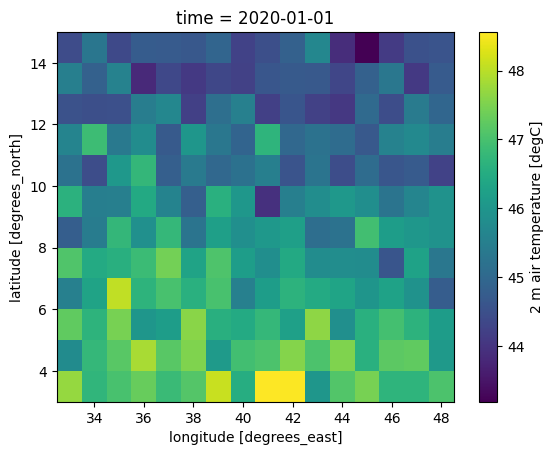

In [46]:
air_temp_subset_et[0,:,:].plot()

### Slice for the time dimension

In [58]:
air_sub_t5 = t2m.sel(time=slice('2020-01-01','2020-01-05'), lat=slice(3,15),lon=slice(33,48))
air_sub_t5.shape

(5, 12, 16)

### Extracting single coordinate

In [60]:
air_temp_ken = t2m.sel(lat=1.29, lon=36.82, method="nearest")
air_temp_ken

<xarray.DataArray 't2m' (time: 10)> Size: 40B
array([47.92221 , 47.54327 , 48.21939 , 48.614594, 48.280994, 49.021957,
       48.78641 , 47.888878, 47.988293, 49.124332], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
    lat      float64 8B 1.5
    lon      float64 8B 37.0
Attributes:
    standard_name:  air_temperature
    long_name:      2 m air temperature
    units:          degC

---

## Plotting with Xarray

- `Xarray's` plotting capabilities are centered around DataArray objects.

In [67]:
# Import Reanalysis data from Copernicus CDS

et_chirps_tp = xr.open_dataset("data/raw/chirps_p05/chirps_p25_2015-2024_clip.nc")
et_chirps_tp

<xarray.Dataset> Size: 42MB
Dimensions:  (time: 3653, lat: 48, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2015-01-01 2015-01-02 ... 2024-12-31
  * lat      (lat) float32 192B 3.125 3.375 3.625 3.875 ... 14.38 14.62 14.88
  * lon      (lon) float32 240B 33.12 33.38 33.62 33.88 ... 47.38 47.62 47.88
Data variables:
    precip   (time, lat, lon) float32 42MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2016-03-02
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [ ]:
# Drop unnecessary variables
# et_era5_tp = et_era5_tp.drop_vars(['expver', 'number'])

# Rename the coordinates for better clarity
# et_era5_tp = et_era5_tp.rename({'latitude': 'lat', 'longitude': 'lon', 'valid_time': 'time'})


# Conver the precipitation from meters to millimeters
# et_era5_tp['tp'] = et_era5_tp['tp'] * 1000.0  # Convert from meters to millimeters
# et_era5_tp['tp'].attrs['units'] = 'mm'  # Update the units attribute

# et_era5_tp


<xarray.Dataset> Size: 44MB
Dimensions:  (time: 3653, lat: 49, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2015-01-01 2015-01-02 ... 2024-12-31
  * lat      (lat) float64 392B 15.0 14.75 14.5 14.25 14.0 ... 3.75 3.5 3.25 3.0
  * lon      (lon) float64 488B 33.0 33.25 33.5 33.75 ... 47.25 47.5 47.75 48.0
Data variables:
    tp       (time, lat, lon) float32 44MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-18T08:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [68]:
et_precip = et_chirps_tp['precip']
et_precip

<xarray.DataArray 'precip' (time: 3653, lat: 48, lon: 60)> Size: 42MB
[10520640 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 29kB 2015-01-01 2015-01-02 ... 2024-12-31
  * lat      (lat) float32 192B 3.125 3.375 3.625 3.875 ... 14.38 14.62 14.88
  * lon      (lon) float32 240B 33.12 33.38 33.62 33.88 ... 47.38 47.62 47.88
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

### Pcolormesh

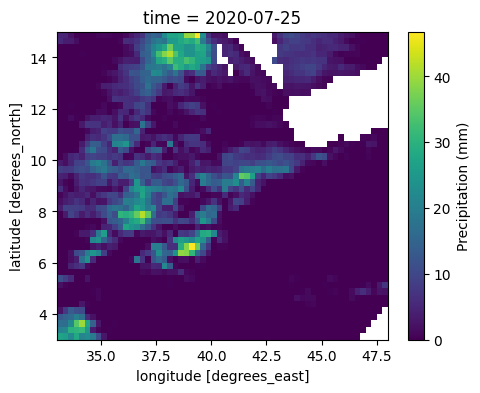

In [69]:
precip_2d = et_precip.sel(time='2020-07-25')
precip_2d.plot.pcolormesh(size=4, 
                       cmap='viridis',
                       cbar_kwargs={'label': 'Precipitation (mm)'},
                       add_colorbar=True)

### Contourf/Contour

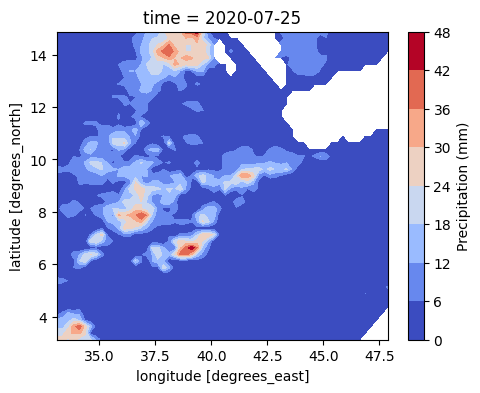

In [70]:
et_precip.sel(time='2020-07-25').plot.contourf(size=4,   # Contourf: filled contours, contour: unfilled
                               levels=10,
                               cbar_kwargs={'label': 'Precipitation (mm)'},
                               add_colorbar=True,
                               cmap='coolwarm')

### Calling Matplotlib functionality

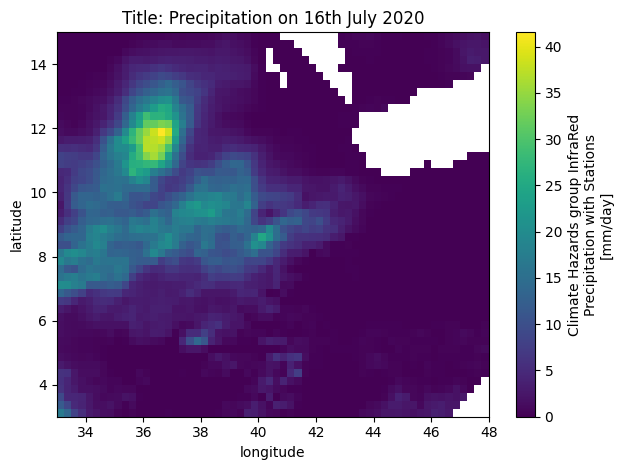

In [71]:
import matplotlib.pyplot as plt

et_precip.sel(time='2020-07-16').plot(cmap=plt.cm.viridis)


plt.title("Title: Precipitation on 16th July 2020")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.tight_layout()
plt.draw()

### Faceted Plots 

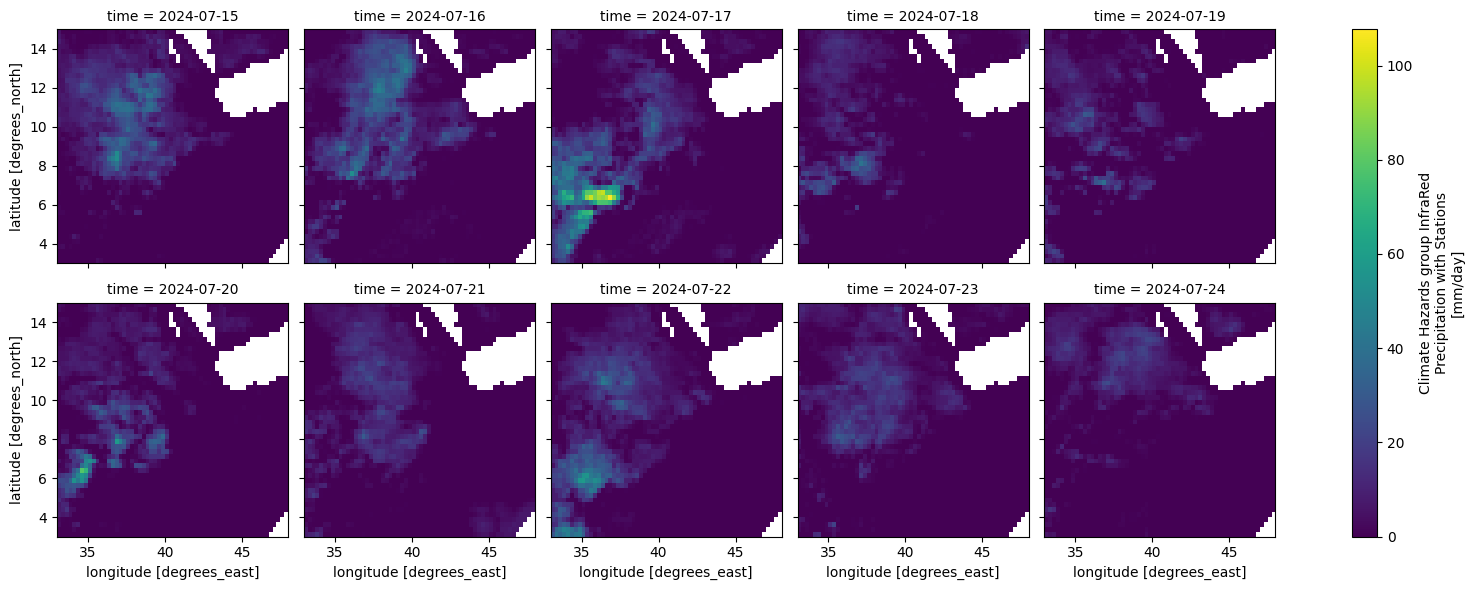

In [72]:
t = et_precip.sel(time=slice('2024-07-15', '2024-07-24'))
g_simple = t.plot(x="lon", y="lat", 
                  col="time", 
                  col_wrap=5, 
                  cmap="viridis", 
                  )


### Time series at fixed location

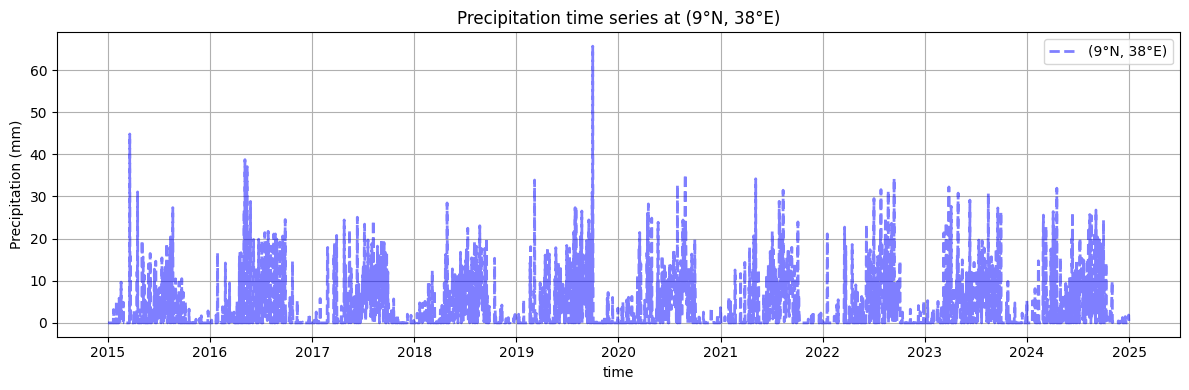

In [73]:
et_precip.sel(lat=9, lon=38, method='nearest').plot(size=4, 
                                                color="b", 
                                                label="(9°N, 38°E)", 
                                                #marker='o', 
                                                markersize=6,
                                                linestyle='--',
                                                linewidth=2,
                                                alpha=0.5,
                                                aspect=3,
                                                )


plt.title("Precipitation time series at (9°N, 38°E)")
plt.ylabel("Precipitation (mm)")
plt.xlabel("time")
plt.legend()
plt.grid()
plt.tight_layout() 
plt.show()


### Time series at fixed location

<Figure size 1200x600 with 0 Axes>

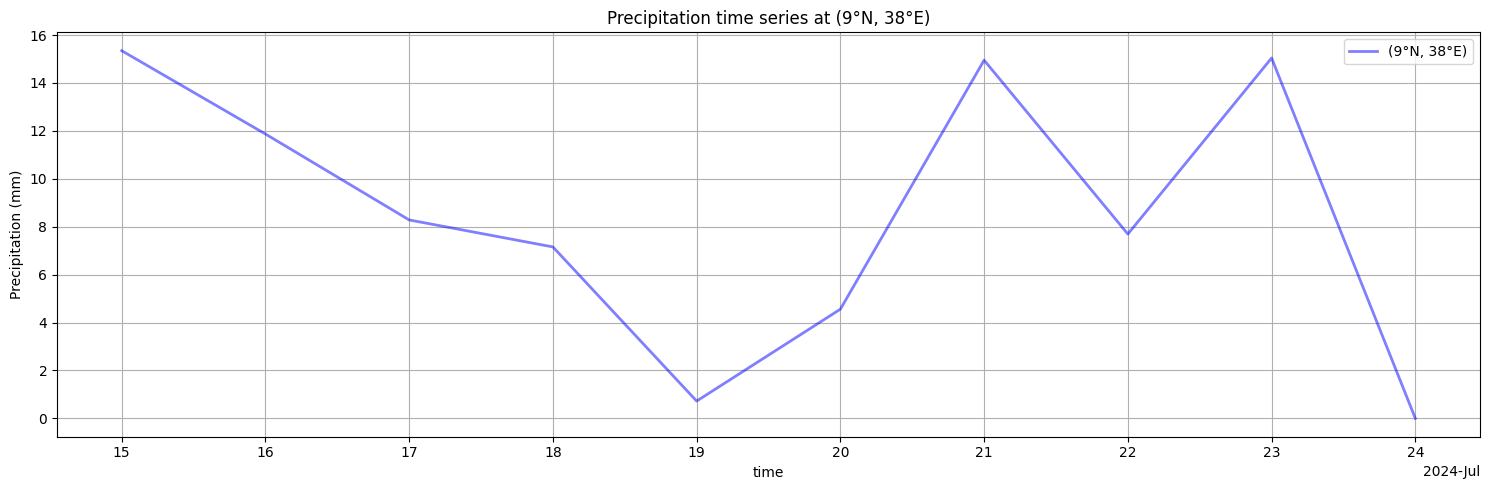

In [74]:
plt.figure(figsize=(12, 6))
et_precip.sel(time=slice('2024-07-15','2024-07-24')).sel(lat=9, lon=38, method='nearest').plot(size=5,
                                                                    color="b", 
                                                                    label="(9°N, 38°E)", 
                                                                    #marker='o', 
                                                                    markersize=6,
                                                                    linestyle='-',
                                                                    linewidth=2,
                                                                    alpha=0.5,
                                                                    aspect=3,
                                                                    )
plt.title("Precipitation time series at (9°N, 38°E)")
plt.ylabel("Precipitation (mm)")
plt.xlabel("time")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

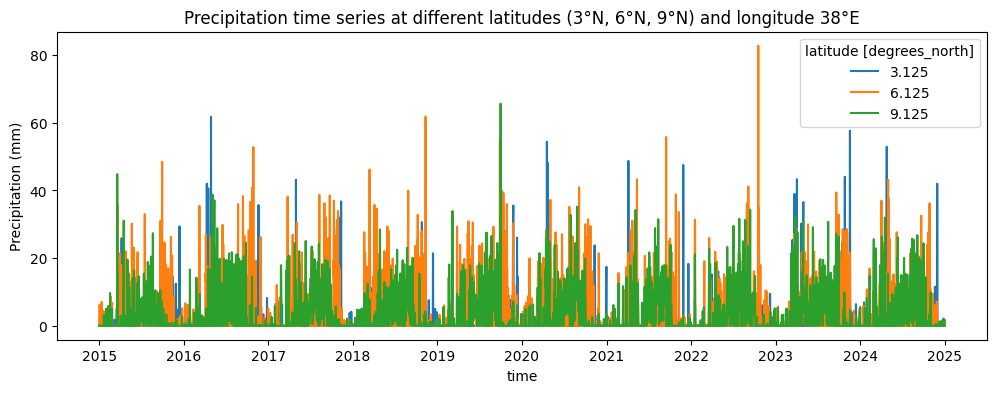

In [77]:
# Plot precipitation time series at different latitudes but same longitude
et_precip.sel(lon=38, lat=[3, 6, 9], method='nearest').plot.line(x="time", aspect=3, size=4)

plt.title("Precipitation time series at different latitudes (3°N, 6°N, 9°N) and longitude 38°E")
plt.ylabel("Precipitation (mm)")
plt.xlabel("time")
plt.show()

### Advanced analysis and plotting

In [ ]:
# Import additional libraries for advanced analysis and plotting
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import TwoSlopeNorm
import xclim as xc
from xclim.indicators import atmos  # ETCCDI indicators
from xclim.indices import standardized_precipitation_index as SPI

---

### Monthly Totals and  Means

In [ ]:
# MONTHLY
pr_mon_sum  = et_precip.resample(time="MS").sum()   # monthly total (mm)
pr_mon_mean = et_precip.resample(time="MS").mean()  # mean daily rate within month (mm/day)

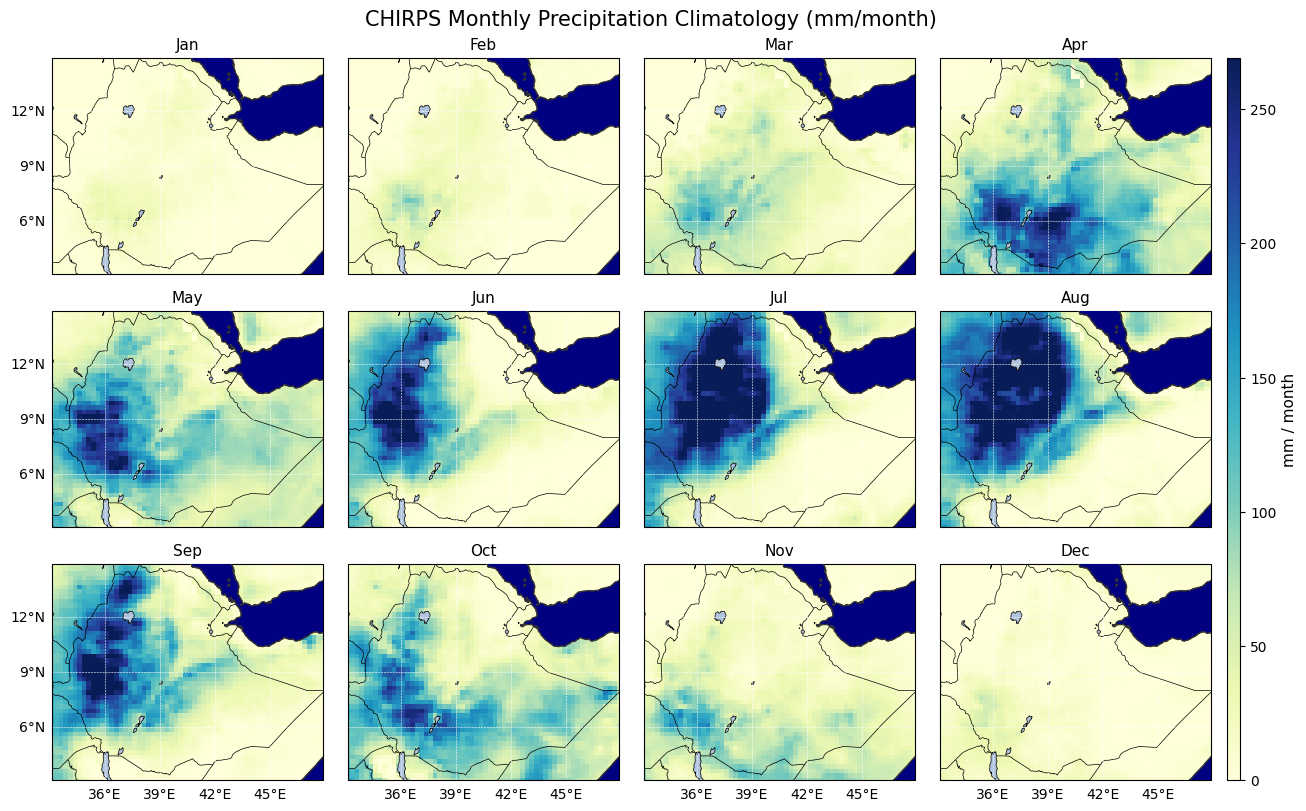

In [179]:
mon_clim = pr_mon_sum.groupby("time.month").mean("time")   # (month, lat, lon)

# --- plotting config
proj = ccrs.PlateCarree()
extent = [float(mon_clim.lon.min()), float(mon_clim.lon.max()),
          float(mon_clim.lat.min()), float(mon_clim.lat.max())]
lon2d, lat2d = np.meshgrid(mon_clim.lon, mon_clim.lat)

# shared color scale
vmin, vmax = 0.0, float(mon_clim.quantile(0.98).values)  # or set vmax=400
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "YlGnBu"

# layout: 3x4 panels + 1 slim colorbar column
fig = plt.figure(figsize=(13, 8), constrained_layout=True)
gs  = fig.add_gridspec(nrows=3, ncols=5, width_ratios=[1,1,1,1,0.045])

axes = [fig.add_subplot(gs[r, c], projection=proj) for r in range(3) for c in range(4)]
cax  = fig.add_subplot(gs[:, 4])

month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def style_axis(ax, left=False, bottom=False):
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="0.2", facecolor="navy")
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor="black", facecolor="lightsteelblue", linewidth=0.5)
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.set_extent(extent, crs=proj)

    # --- THIS is the important change ---
    gl = ax.gridlines(crs=proj, draw_labels=True,
                      linewidth=0.4, color="white", linestyle="--",
                      x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = left
    gl.bottom_labels = bottom
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    # set locators AFTER creating gridliner
    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

mappables = []
for i, ax in enumerate(axes):
    month = i + 1
    da = mon_clim.sel(month=month)
    im = ax.pcolormesh(lon2d, lat2d, da.values, transform=proj,
                       cmap=cmap, norm=norm, shading="auto")
    ax.set_title(month_labels[i], fontsize=11, pad=6)
    style_axis(ax, left=(i % 4 == 0), bottom=(i // 4 == 2))
    mappables.append(im)

# single colorbar with units
cb = fig.colorbar(mappables[0], cax=cax)
cb.set_label("mm / month", fontsize=11)

fig.suptitle("CHIRPS Monthly Precipitation Climatology (mm/month)", fontsize=15)
plt.show()

---
### Seasonal Total and Mean Rainfall

In [ ]:
# SEASONAL (DJF, MAM, JJA, SON) using quarters anchored to Dec
pr_sea_sum  = et_precip.resample(time="QS-DEC").sum()   # seasonal total
pr_sea_mean = et_precip.resample(time="QS-DEC").mean()  # mean daily rate in season

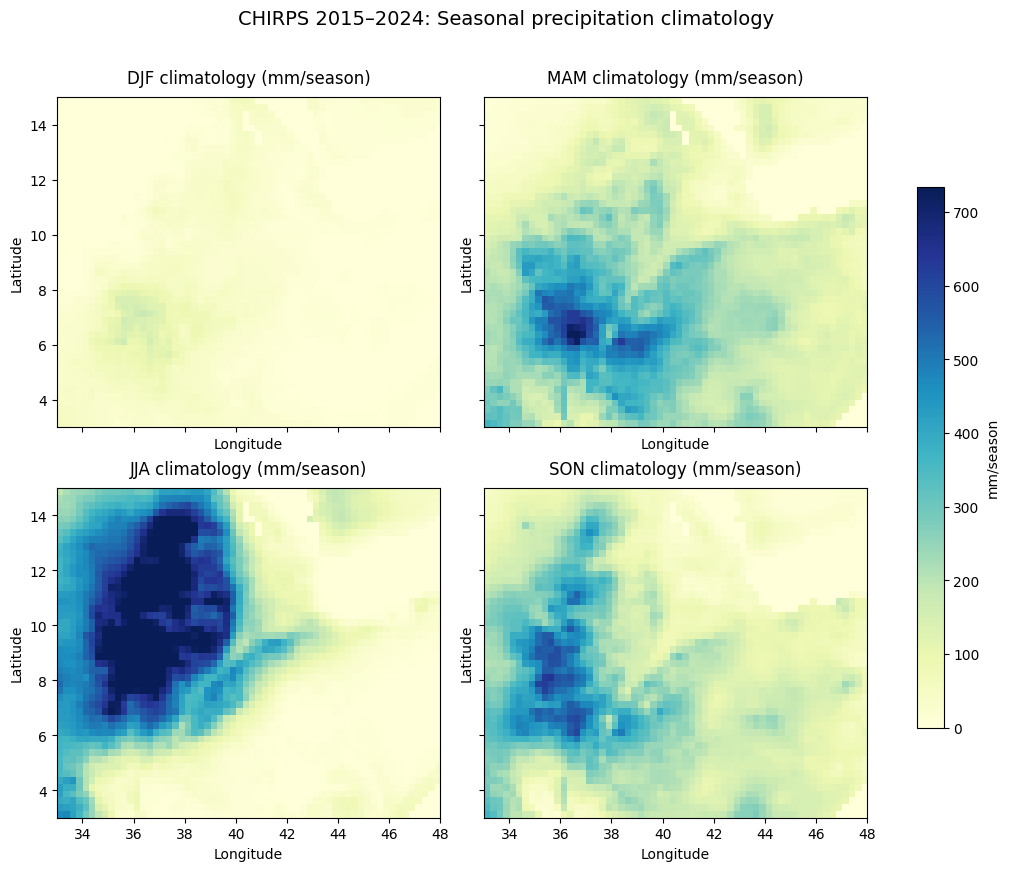

In [180]:
# Seasonal totals
sea_total = et_precip.resample(time="QS-DEC").sum()                 # seasonal totals by season/year

# Then climatological mean per season (mm/season)
sea_clim  = sea_total.groupby("time.season").mean("time")            # (season, lat, lon)

# Ensure conventional season order
seasons = [s for s in ["DJF","MAM","JJA","SON"] if s in sea_clim.season.values]
sea_clim = sea_clim.sel(season=seasons)

# Use a common color scale across all panels
vmin = 0.0
vmax = float(sea_clim.quantile(0.98).values)

# sea_clim.max().values   
#float(sea_clim.quantile(0.98).values)  # robust upper bound

# Plot 2×2 with shared colorbar
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True, sharex=True, sharey=True)

ims = []

for ax, s in zip(axes.ravel(), seasons):
    im = sea_clim.sel(season=s).plot.imshow(
        x="lon", y="lat", 
        ax=ax, 
        cmap="YlGnBu", # precipitation colors: Blues, viridis, cividis, turbo, nipy_spectral
        vmin=vmin, 
        vmax=vmax, 
        add_colorbar=False
    )
    ims.append(im)
    ax.set_title(f"{s} climatology (mm/season)")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

# shared colorbar
fig.colorbar(ims[0], 
             ax=axes.ravel().tolist(), 
             shrink=0.75, 
             label="mm/season")
plt.suptitle("CHIRPS 2015–2024: Seasonal precipitation climatology", y=1.07, fontsize=14)

plt.show()

### 

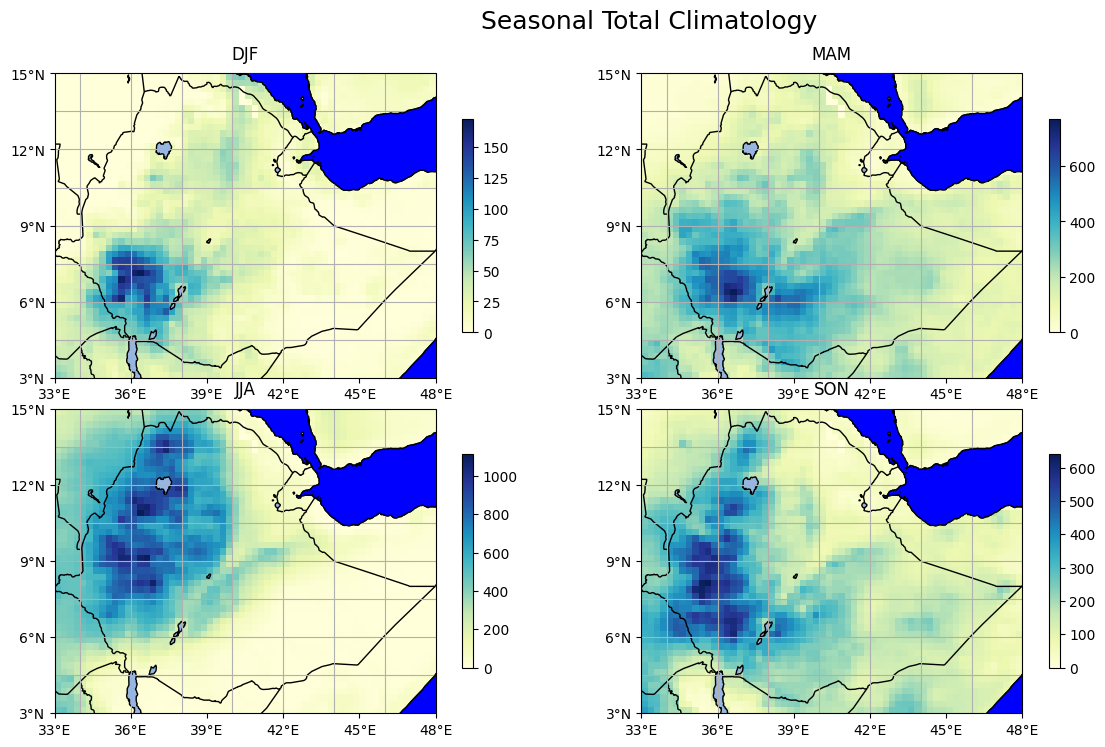

In [183]:
plt.figure(figsize=(16, 8))
plt.rcParams['axes.titlesize'] =12
plt.rcParams['axes.titlepad'] =10

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.4, wspace=0.4, hspace=0.4)

plt.suptitle("Seasonal Total Climatology",  fontsize=18)
lon2d, lat2d = np.meshgrid(sea_clim.lon, sea_clim.lat)
extent = [33, 48, 3, 15]
central_lon, central_lat = 37,7

ax1 = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=central_lon, globe=None))
ct1 = ax1.pcolormesh(lon2d, lat2d, sea_clim.sel(season='DJF'), 
                     transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', facecolor='blue')
ax1.add_feature(cfeature.BORDERS, edgecolor='black')
ax1.add_feature(cfeature.LAKES, edgecolor='black')
ax1.coastlines(resolution='10m')
ax1.set_extent(extent)
ax1.gridlines()
ax1.set_xticks(np.arange(33,49,3), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(3,16,3), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(ct1 ,orientation="vertical",extendrect='True', shrink = 0.7)
ax1.set(title="DJF")

ax2 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=central_lon, globe=None))
ct2 = ax2.pcolormesh(lon2d, lat2d, sea_clim.sel(season='MAM'),
                     transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', facecolor='blue')
ax2.add_feature(cfeature.BORDERS, edgecolor='black')
ax2.add_feature(cfeature.LAKES, edgecolor='black')
ax2.coastlines(resolution='10m')
ax2.set_extent(extent)
ax2.gridlines()
ax2.set_xticks(np.arange(33,49,3), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(3,16,3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(ct2 ,orientation="vertical",extendrect='True', shrink = 0.7)
#cb.set_label("K", fontsize=12)
ax2.set(title="MAM")

ax3 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=central_lon, globe=None))
ct3 = ax3.pcolormesh(lon2d, lat2d, sea_clim.sel(season='JJA'), 
                     transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax3.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', facecolor='blue')
ax3.add_feature(cfeature.BORDERS, edgecolor='black')
ax3.add_feature(cfeature.LAKES, edgecolor='black')
ax3.coastlines(resolution='10m')
ax3.set_extent(extent)
ax3.gridlines()
ax3.set_xticks(np.arange(33,49,3), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(3,16,3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(ct3 ,orientation="vertical",extendrect='True', shrink = 0.7)
# cb.set_label("K", fontsize=12)
ax3.set(title="JJA")


ax3 = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=central_lon, globe=None))
ct3 = ax3.pcolormesh(lon2d, lat2d, sea_clim.sel(season='SON'), 
                     transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax3.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', facecolor='blue')
ax3.add_feature(cfeature.BORDERS, edgecolor='black')
ax3.add_feature(cfeature.LAKES, edgecolor='black')
ax3.coastlines(resolution='10m')
ax3.set_extent(extent)
ax3.gridlines()
ax3.set_xticks(np.arange(33,49,3), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(3,16,3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(ct3 ,orientation="vertical",extendrect='True', shrink = 0.7)
# cb.set_label("K", fontsize=12)
ax3.set(title="SON")


plt.subplots_adjust(top=0.9, right=0.8, wspace=0.1, hspace=0.1)
#plt.savefig('sub.jpeg', transparent=True,  bbox_inches='tight', dpi=800)
plt.show()

### Seasonal Total Climatology (ONDJ-FMAM-JJAS) 

- ET case 

In [240]:
## monthly totals, then monthly climatology (mean monthly totals across years)
pr_mon_total = et_precip.resample(time="MS").sum()
mon_clim = pr_mon_total.groupby("time.month").mean("time")  # (month, lat, lon)

# --- 2) Build custom 4-month seasonal CLIMATOLOGY (mm/season)
seasons_4m = {
    "ONDJ": [10, 11, 12, 1],
    "FMAM": [2, 3, 4, 5],
    "JJAS": [6, 7, 8, 9],
}
# Sum the monthly climatologies across the months of each custom season
sea4 = []
names = []
for name, months in seasons_4m.items():
    sea4.append(mon_clim.sel(month=months).sum("month"))
    names.append(name)
sea4 = xr.concat(sea4, dim="season").assign_coords(season=("season", names))  # (season, lat, lon)

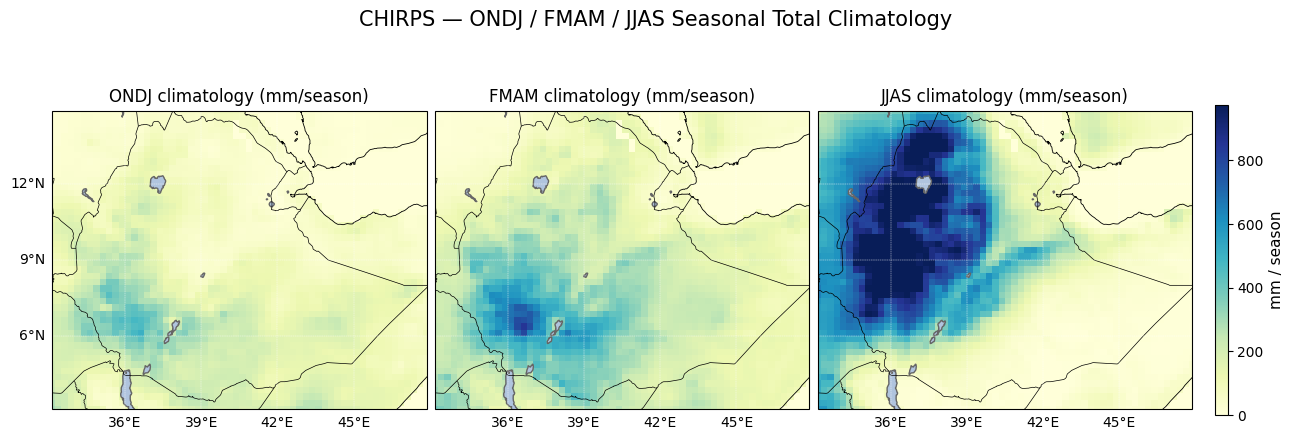

In [ ]:
# --- 3) Plot: 1×3 panels with shared colorbar (no loops)
proj = ccrs.PlateCarree()
extent = [float(sea4.lon.min()), float(sea4.lon.max()),
          float(sea4.lat.min()), float(sea4.lat.max())]

# common color scale for all three panels
vmin = 0.0
vmax = float(sea4.quantile(0.98).values)  # or set a fixed value, e.g., 600
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "YlGnBu"

# layout: 1x3 maps + 1 slim colorbar column
fig = plt.figure(figsize=(13, 4.8), constrained_layout=True)
gs  = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.045])

ax_ondj = fig.add_subplot(gs[0, 0], projection=proj)
ax_fmam = fig.add_subplot(gs[0, 1], projection=proj)
ax_jjas = fig.add_subplot(gs[0, 2], projection=proj)

def style_axis(ax, left=True, bottom=True):
    ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2")
    ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.set_extent(extent, crs=proj)

    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.3, color="white",
                      linestyle="--", x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels  = left
    gl.bottom_labels = bottom
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

# --- ONDJ
da_ondj = sea4.sel(season="ONDJ")
im_ondj = ax_ondj.pcolormesh(da_ondj.lon, da_ondj.lat, da_ondj,
                             transform=proj, cmap=cmap, norm=norm, shading="auto")
ax_ondj.set_title("ONDJ climatology (mm/season)", fontsize=12, pad=6)
style_axis(ax_ondj, left=True, bottom=True)

# --- FMAM
da_fmam = sea4.sel(season="FMAM")
im_fmam = ax_fmam.pcolormesh(da_fmam.lon, da_fmam.lat, da_fmam,
                             transform=proj, cmap=cmap, norm=norm, shading="auto")
ax_fmam.set_title("FMAM climatology (mm/season)", fontsize=12, pad=6)
style_axis(ax_fmam, left=False, bottom=True)

# --- JJAS
da_jjas = sea4.sel(season="JJAS")
im_jjas = ax_jjas.pcolormesh(da_jjas.lon, da_jjas.lat, da_jjas,
                             transform=proj, cmap=cmap, norm=norm, shading="auto")
ax_jjas.set_title("JJAS climatology (mm/season)", fontsize=12, pad=6)
style_axis(ax_jjas, left=False, bottom=True)

# shared colorbar (any of the three mappables will do since they share the same norm)
cb = fig.colorbar(
    im_ondj,                      # any of your mappables (they share same norm)
    ax=[ax_ondj, ax_fmam, ax_jjas],
    shrink=0.7,                   # now works
    aspect=25,                    # thinner/thicker bar (length-to-width ratio)
    pad=0.02                      # gap between maps and colorbar
)
cb.set_label("mm / season", fontsize=11)

fig.suptitle("CHIRPS — ONDJ / FMAM / JJAS Seasonal Total Climatology", fontsize=15)
plt.show()


---

## Mean Annual Total Rainfall Map

In [ ]:
# ANNUAL (Jan–Dec)
pr_ann_sum  = et_precip.resample(time="YS").sum()   # annual total
pr_ann_mean = et_precip.resample(time="YS").mean()  # annual mean daily rate

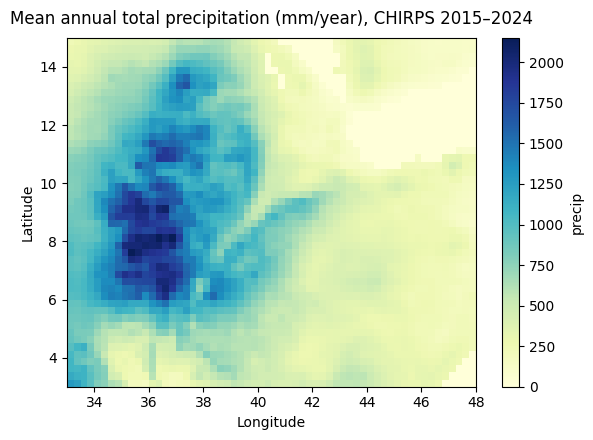

In [185]:
# Then climatological mean (mm/year)
mean_annual = pr_ann_sum.mean("time")       # (lat, lon)

# Plot
plt.figure(figsize=(6,4.5))
mean_annual.plot.imshow(x="lon", y="lat", cmap="YlGnBu")
plt.title("Mean annual total precipitation (mm/year), CHIRPS 2015–2024")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

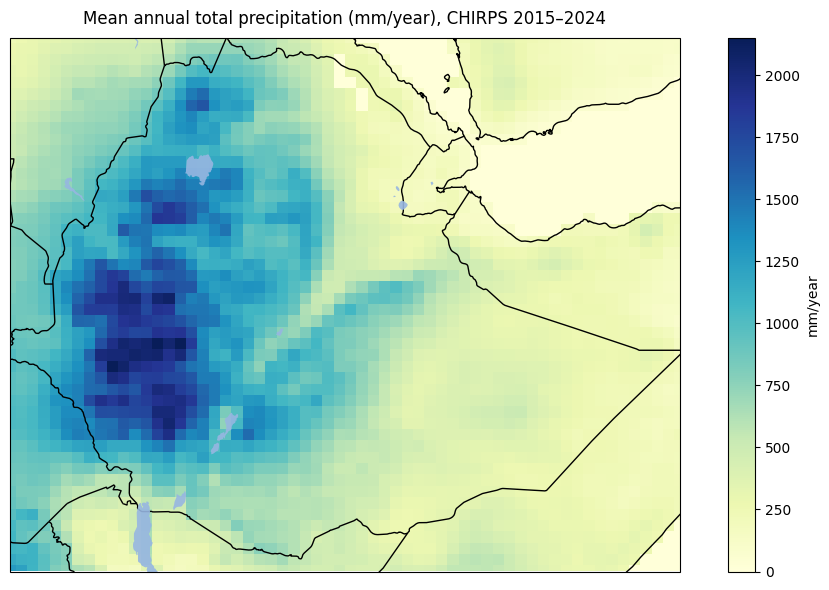

In [190]:
# Plot with Cartopy
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add data
im = mean_annual.plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="YlGnBu",
    add_colorbar=True,
    cbar_kwargs={"label": "mm/year"}
)

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle="-")
ax.add_feature(cfeature.LAKES, alpha=0.9)
#ax.add_feature(cfeature.RIVERS)

# Set title and labels
ax.set_title("Mean annual total precipitation (mm/year), CHIRPS 2015–2024")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Set extent (optional, adjust as needed)
ax.set_extent([mean_annual.lon.min(), mean_annual.lon.max(), mean_annual.lat.min(), mean_annual.lat.max()], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

---

## Daily Anomaly 

In [ ]:
# DAILY CLIMATOLOGY (choose your baseline; here we use all years in file)
yr0, yr1 = int(et_precip.time.dt.year.min()), int(et_precip.time.dt.year.max())
base = et_precip.sel(time=slice(f"{yr0}-01-01", f"{yr1}-12-31"))

# Drop Feb 29 for climatology
is_feb29 = (base.time.dt.month==2) & (base.time.dt.day==29)
base_no_leap = base.where(~is_feb29, drop=True)

# Mean by day-of-year → daily climatology (mm/day)
daily_clim = base_no_leap.groupby("time.dayofyear").mean("time")

# Drop Feb 29 from the full series before anomaly calculation
et_precip_no_leap = et_precip.where(~((et_precip.time.dt.month==2) & (et_precip.time.dt.day==29)), drop=True)

# ---- DAILY ANOMALY (mm/day)
daily_anom = et_precip_no_leap.groupby("time.dayofyear") - daily_clim

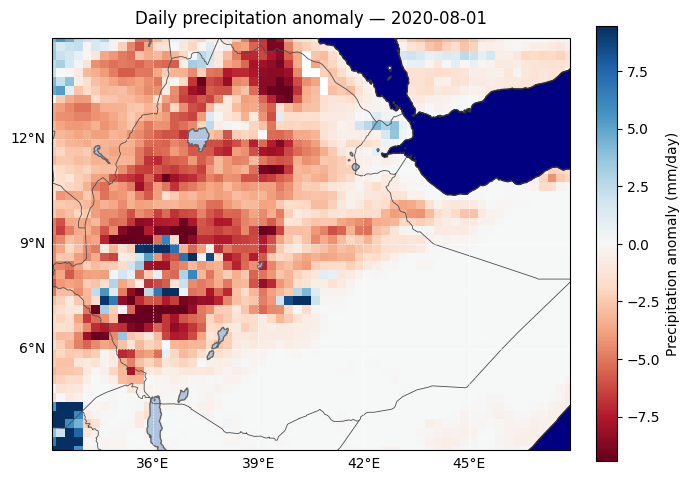

In [198]:
# Pick a date present in your file (string or Timestamp)
target_date = "2020-08-01"
da = daily_anom.sel(time=np.datetime64(target_date))  # (lat, lon) anomaly for that day

# ---- plot (Cartopy)
proj = ccrs.PlateCarree()
extent = [float(et_precip.lon.min()), float(et_precip.lon.max()),
          float(et_precip.lat.min()), float(et_precip.lat.max())]

# Robust symmetric color limits around zero
lim = float(da.pipe(np.abs).quantile(0.98).values)  # 98th percentile of |anom|
norm = TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

fig = plt.figure(figsize=(6.8, 5.2), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(et_precip.lon, et_precip.lat, da, transform=proj,
                    cmap="RdBu", norm=norm, shading="auto")

ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2", zorder=100)
ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
ax.add_feature(cfeature.BORDERS, edgecolor="0.3", linewidth=0.6)
ax.coastlines(resolution="10m", linewidth=0.6)
ax.set_extent(extent, crs=proj)

# Gridlines (set locators AFTER creating gridliner)
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.4, color="white",
                  linestyle="--", x_inline=False, y_inline=False)
gl.top_labels = False; gl.right_labels = False
gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

cb = fig.colorbar(im, ax=ax, shrink=0.85)
cb.set_label("Precipitation anomaly (mm/day)")

ax.set_title(f"Daily precipitation anomaly — {pd.to_datetime(target_date).date()}")
plt.show()

---
## Monthly Anomaly 

In [201]:
# --- Monthly totals (mm/month)
pr_mon = et_precip.resample(time="MS").sum()

# --- Choose baseline for climatology (here: all years in the file)
yr0, yr1 = int(et_precip.time.dt.year.min()), int(et_precip.time.dt.year.max())
base = et_precip.sel(time=slice(f"{yr0}-01-01", f"{yr1}-12-31"))
base_mon = base.resample(time="MS").sum()
mon_clim = base_mon.groupby("time.month").mean("time")    # (month, lat, lon)

# --- Monthly difference anomaly (mm/month)
mon_anom = pr_mon.groupby("time.month") - mon_clim

# --- (Optional) Monthly percent of normal (%)
mon_pon = (pr_mon.groupby("time.month") / mon_clim - 1.0) * 100.0


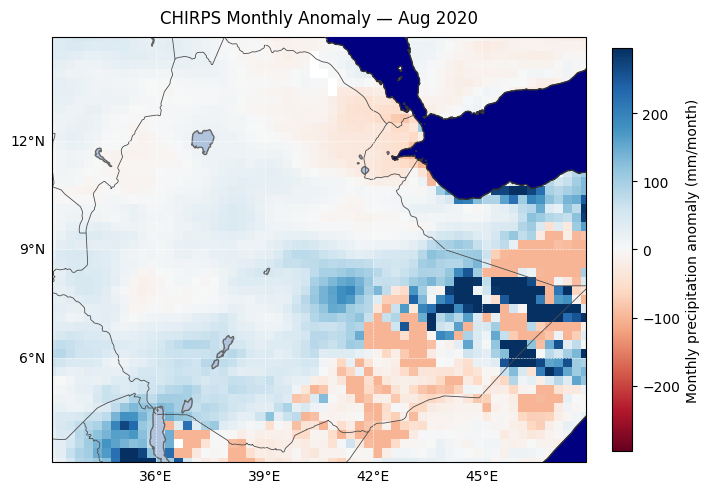

In [206]:
# Pick a month present in your data
target_month = "2020-08"  # YYYY-MM (first of month after resample)
da = mon_pon.sel(time=np.datetime64(target_month))  # (lat, lon), mm/month

proj = ccrs.PlateCarree()
extent = [float(mon_pon.lon.min()), float(mon_pon.lon.max()),
          float(mon_pon.lat.min()), float(mon_pon.lat.max())]

# symmetric color scale about zero
# lim = float(np.nanquantile(np.abs(da.values), 0.98))
# norm = TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

vmin = mon_pon.min().values
vmax = mon_pon.max().values

fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(mon_pon.lon, mon_pon.lat, da, transform=proj,
                    cmap="RdBu", norm=norm, shading="auto")

ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2", zorder=100)
ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
ax.add_feature(cfeature.BORDERS, edgecolor="0.3", linewidth=0.6)
ax.coastlines(resolution="10m", linewidth=0.6)
ax.set_extent(extent, crs=proj)

gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.4, color="white",
                  linestyle="--", x_inline=False, y_inline=False)
gl.top_labels = False; gl.right_labels = False
gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

cb = fig.colorbar(im, ax=ax, shrink=0.85)
cb.set_label("Monthly precipitation anomaly (mm/month)")
ax.set_title(f"CHIRPS Monthly Anomaly — {pd.to_datetime(target_month).strftime('%b %Y')}")
plt.show()


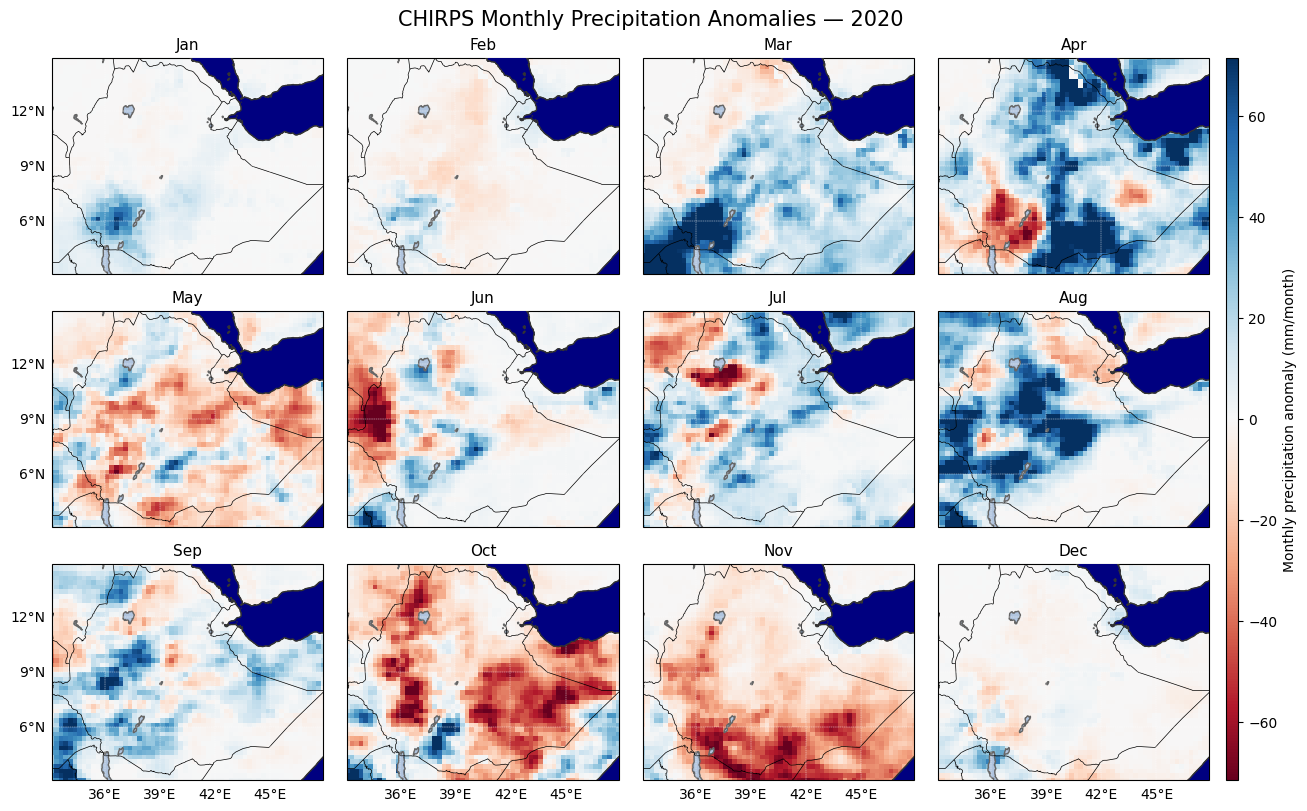

In [216]:
year = 2020
sub = mon_anom.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))

# Ensure we have exactly 12 months (resample "MS" gives first of each month)
dates = pd.date_range(f"{year}-01-01", f"{year}-12-01", freq="MS")
sub = sub.sel(time=dates)

# consistent, zero-centered scale across all 12 panels
lim = float(np.nanquantile(np.abs(sub.values), 0.98))
norm = TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

fig = plt.figure(figsize=(13, 8), constrained_layout=True)
gs  = fig.add_gridspec(nrows=3, ncols=5, width_ratios=[1,1,1,1,0.045])
proj = ccrs.PlateCarree()

axes = [fig.add_subplot(gs[r, c], projection=proj) for r in range(3) for c in range(4)]
cax  = fig.add_subplot(gs[:, 4])

def style_axis(ax, left=False, bottom=False):
    ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2", zorder=100)
    ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.set_extent(extent, crs=proj)
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.3, color="white",
                      linestyle="--", x_inline=False, y_inline=False)
    gl.top_labels = False; gl.right_labels = False
    gl.left_labels  = left
    gl.bottom_labels = bottom
    gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

mappables = []
for i, (ax, t) in enumerate(zip(axes, dates)):
    da = sub.sel(time=t)
    im = ax.pcolormesh(et_precip.lon, et_precip.lat, da, transform=proj,
                       cmap="RdBu", norm=norm, shading="auto")
    ax.set_title(pd.to_datetime(str(t)).strftime("%b"), fontsize=11, pad=6)
    style_axis(ax, left=(i % 4 == 0), bottom=(i // 4 == 2))
    mappables.append(im)

cb = fig.colorbar(mappables[0], cax=cax)
cb.set_label("Monthly precipitation anomaly (mm/month)")
fig.suptitle(f"CHIRPS Monthly Precipitation Anomalies — {year}", fontsize=15)
plt.show()


---

## Seasonal Anomaly 

In [217]:
# --- Seasonal totals (mm/season); quarters anchored to DEC → seasons: DJF, MAM, JJA, SON
sea_total = et_precip.resample(time="QS-DEC").sum()     # time stamps at season start: Dec/Mar/Jun/Sep

# Baseline (use all years in file; replace with "1991-01-01"..."2020-12-31" if desired)
yr0, yr1 = int(et_precip.time.dt.year.min()), int(et_precip.time.dt.year.max())
base_total = et_precip.sel(time=slice(f"{yr0}-01-01", f"{yr1}-12-31")).resample(time="QS-DEC").sum()

# Seasonal climatology (mm/season) and anomalies (mm/season)
sea_clim = base_total.groupby("time.season").mean("time")         # (season, lat, lon)
sea_anom = sea_total.groupby("time.season") - sea_clim            # (time, lat, lon)

# (Optional) Seasonal % of normal
sea_pon  = (sea_total.groupby("time.season") / sea_clim - 1.0) * 100.0


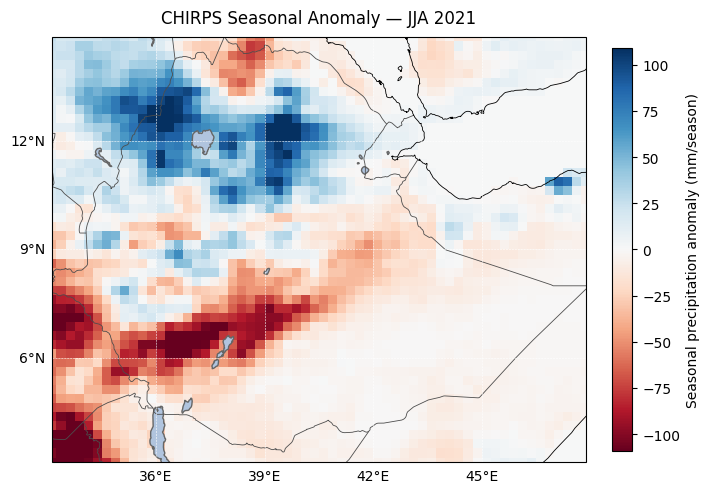

In [229]:
# Example: map **JJA 2021** anomaly → stamped "2021-06-01"
target = np.datetime64("2021-06-01")
da = sea_anom.sel(time=target)  # (lat, lon)

proj = ccrs.PlateCarree()
extent = [float(et_precip.lon.min()), float(et_precip.lon.max()),
          float(et_precip.lat.min()), float(et_precip.lat.max())]

# Zero-centered robust limits
# lim = float(np.nanquantile(np.abs(da.values), 0.98))
# norm = TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

vmin = sea_pon.min().values
vmax = sea_pon.max().values

fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(et_precip.lon, et_precip.lat, da, transform=proj,
                    cmap="RdBu", norm=norm, shading="auto")

ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2")
ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
ax.add_feature(cfeature.BORDERS, edgecolor="0.3", linewidth=0.6)
ax.coastlines(resolution="10m", linewidth=0.6)
ax.set_extent(extent, crs=proj)

gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.4, color="white",
                  linestyle="--", x_inline=False, y_inline=False)
gl.top_labels = False; gl.right_labels = False
gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

cb = fig.colorbar(im, ax=ax, shrink=0.85)
cb.set_label("Seasonal precipitation anomaly (mm/season)")
ax.set_title("CHIRPS Seasonal Anomaly — JJA 2021")
plt.show()


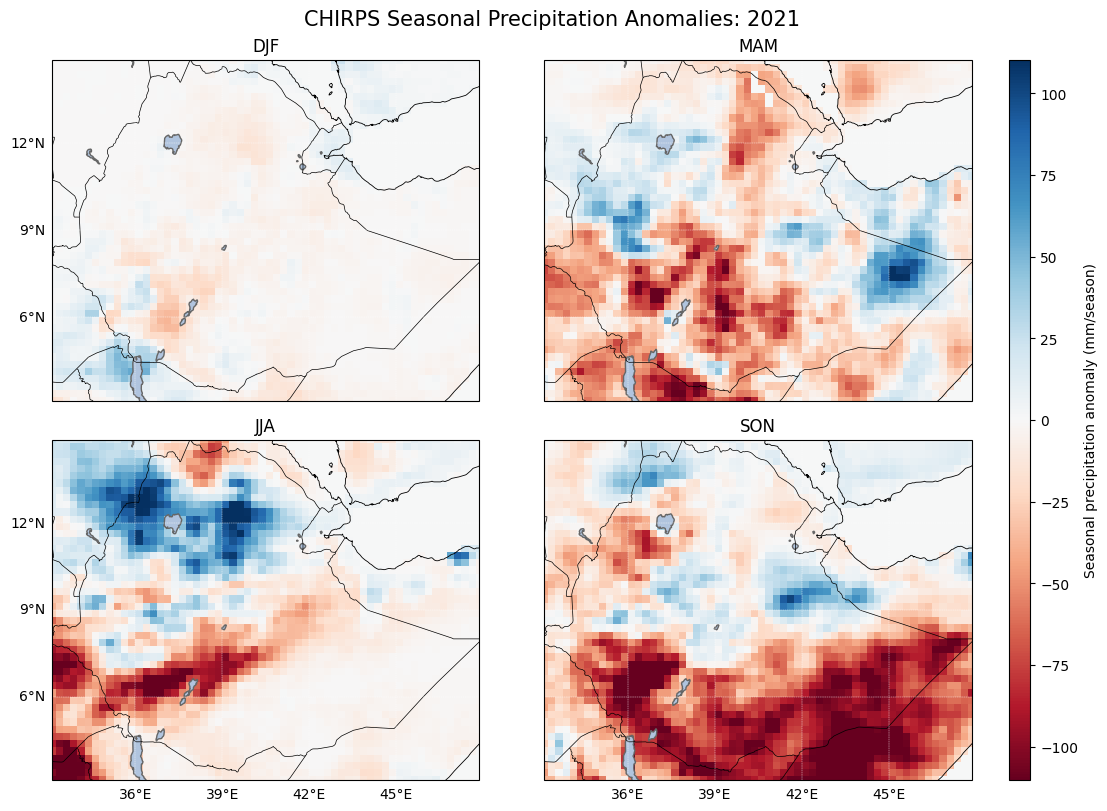

In [ ]:
def season_starts_for_year(year: int):
    """Return [DJF, MAM, JJA, SON] start timestamps for a given 'season-year'."""
    # DJF year Y → starts Dec (Y-1), then Mar/Jun/Sep (Y)
    return [
        np.datetime64(f"{year-1}-12-01"),  # DJF of 'year'
        np.datetime64(f"{year}-03-01"),    # MAM
        np.datetime64(f"{year}-06-01"),    # JJA
        np.datetime64(f"{year}-09-01"),    # SON
    ]

year = 2021
times = season_starts_for_year(year)
sub = sea_anom.sel(time=times)  # (time=4, lat, lon)

# Consistent symmetric scale across the 4 seasons
lim = float(np.nanquantile(np.abs(sub.values), 0.98))
norm = TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

labels = ["DJF", "MAM", "JJA", "SON"]

fig = plt.figure(figsize=(11, 8), constrained_layout=True)
gs  = fig.add_gridspec(2, 3, width_ratios=[1,1,0.045])
proj = ccrs.PlateCarree()

axes = [fig.add_subplot(gs[0,0], projection=proj),
        fig.add_subplot(gs[0,1], projection=proj),
        fig.add_subplot(gs[1,0], projection=proj),
        fig.add_subplot(gs[1,1], projection=proj)]
cax  = fig.add_subplot(gs[:, 2])

def style_axis(ax, left=False, bottom=False):
    ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2")
    ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.set_extent(extent, crs=proj)
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.3, color="white",
                      linestyle="--", x_inline=False, y_inline=False)
    gl.top_labels = False; gl.right_labels = False
    gl.left_labels  = left
    gl.bottom_labels = bottom
    gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

mappables = []
for i, (ax, t, lab) in enumerate(zip(axes, times, labels)):
    da = sea_anom.sel(time=t)
    im = ax.pcolormesh(et_precip.lon, et_precip.lat, da, transform=proj,
                       cmap="RdBu", norm=norm, shading="auto")
    ax.set_title(lab, fontsize=12, pad=6)
    style_axis(ax, left=(i % 2 == 0), bottom=(i // 2 == 1))
    mappables.append(im)

cb = fig.colorbar(mappables[0], cax=cax)
cb.set_label("Seasonal precipitation anomaly (mm/season)")

fig.suptitle(f"CHIRPS Seasonal Precipitation Anomalies: {year}", fontsize=15)
plt.show()


---
## Annual Anomaly

In [230]:
# --- Annual totals (calendar-year, Jan–Dec)
pr_ann = et_precip.resample(time="YS").sum()          # mm/year, stamped at Jan-01 of each year

# --- Baseline for climatology (use all years in file; replace with 1991–2020 if preferred)
yr0, yr1 = int(et_precip.time.dt.year.min()), int(et_precip.time.dt.year.max())
base_ann = et_precip.sel(time=slice(f"{yr0}-01-01", f"{yr1}-12-31")).resample(time="YS").sum()

# --- Climatology & anomalies
ann_clim = base_ann.mean("time")               # (lat, lon), mm/year
ann_anom = pr_ann - ann_clim                   # (time, lat, lon), mm/year
ann_pon  = (pr_ann / ann_clim - 1.0) * 100.0   # % of normal


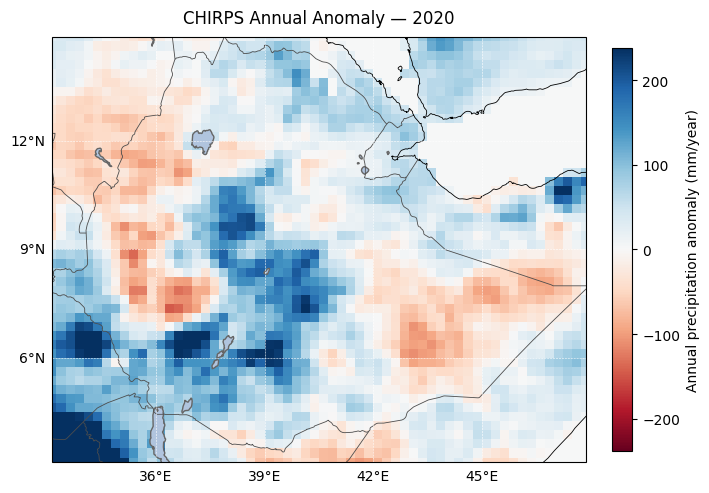

In [231]:
# Pick a year present in your data (remember: 'YS' puts the time at Jan-01)
year = 2020
da = ann_anom.sel(time=np.datetime64(f"{year}-01-01"))   # (lat, lon)

proj = ccrs.PlateCarree()
extent = [float(et_precip.lon.min()), float(et_precip.lon.max()),
          float(et_precip.lat.min()), float(et_precip.lat.max())]

# Zero-centered robust limits
lim = float(np.nanquantile(np.abs(da.values), 0.98))
norm = TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(et_precip.lon, et_precip.lat, da, transform=proj,
                    cmap="RdBu", norm=norm, shading="auto")

ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2")
ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
ax.add_feature(cfeature.BORDERS, edgecolor="0.3", linewidth=0.6)
ax.coastlines(resolution="10m", linewidth=0.6)
ax.set_extent(extent, crs=proj)

gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.4, color="white",
                  linestyle="--", x_inline=False, y_inline=False)
gl.top_labels = False; gl.right_labels = False
gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

cb = fig.colorbar(im, ax=ax, shrink=0.85)
cb.set_label("Annual precipitation anomaly (mm/year)")
ax.set_title(f"CHIRPS Annual Anomaly — {year}")
plt.show()


---
## CDD and CWD

In [267]:
# normalize names
if "latitude" in et_chirps_tp.dims:  et_chirps_tp = et_chirps_tp.rename({"latitude": "lat"})
if "longitude" in et_chirps_tp.dims: et_chirps_tp = et_chirps_tp.rename({"longitude": "lon"})

# pick precip var
for v in ["precip", "pr", "precipitation","tp"]:
    if v in et_chirps_tp.data_vars:
        pr = et_chirps_tp[v]; break
else:
    raise KeyError("precip variable not found")

# ensure ascending lat & sorted daily time
if pr.lat[0] > pr.lat[-1]:
    pr = pr.sortby("lat")
pr = pr.sortby("time")

# xclim expects physical units
pr = pr.assign_attrs(units="mm/day")  # CHIRPS daily is mm/day


In [ ]:
# Calendar-year (Jan–Dec).  Use freq="AS-OCT" for hydrological Oct–Sep.
CDD = atmos.maximum_consecutive_dry_days(pr, thresh="1 mm/day", freq="YS")   # days, shape: (time, lat, lon)
CWD = atmos.maximum_consecutive_wet_days(pr, thresh="1 mm/day", freq="YS")   # days

# Mean maps over the analysis years
CDD_mean = CDD.mean("time")
CWD_mean = CWD.mean("time")

c:\Users\yonas\Documents\ICPAC\python-ml-gha-venv\Lib\site-packages\xclim\core\cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
c:\Users\yonas\Documents\ICPAC\python-ml-gha-venv\Lib\site-packages\xclim\core\cfchecks.py:79: UserWarning: Variable has a non-conforming standard_name: Got `convective precipitation rate`, expected `['precipitation_flux']`
  check_valid(vardata, "standard_name", data["standard_name"])
c:\Users\yonas\Documents\ICPAC\python-ml-gha-venv\Lib\site-packages\xclim\core\cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
c:\Users\yonas\Documents\ICPAC\python-ml-gha-venv\Lib\site-packages\xclim\core\cfchecks.py:79: UserWarning: Variable has a non-conforming standard_name: Got `convective precipitation rate`, expected `['precipitation_flux']`
  c

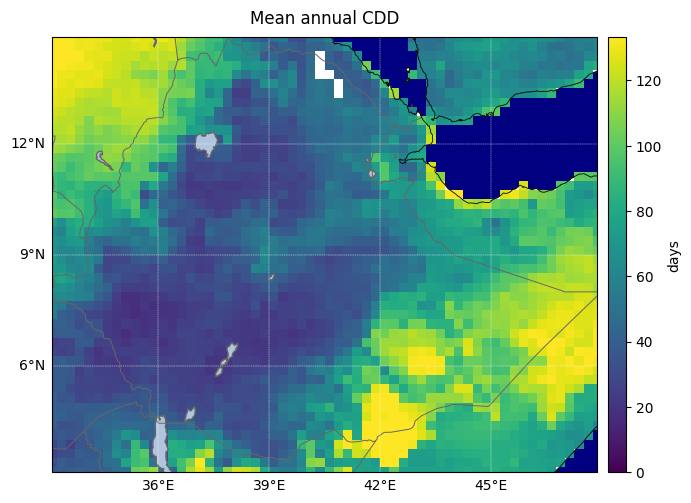

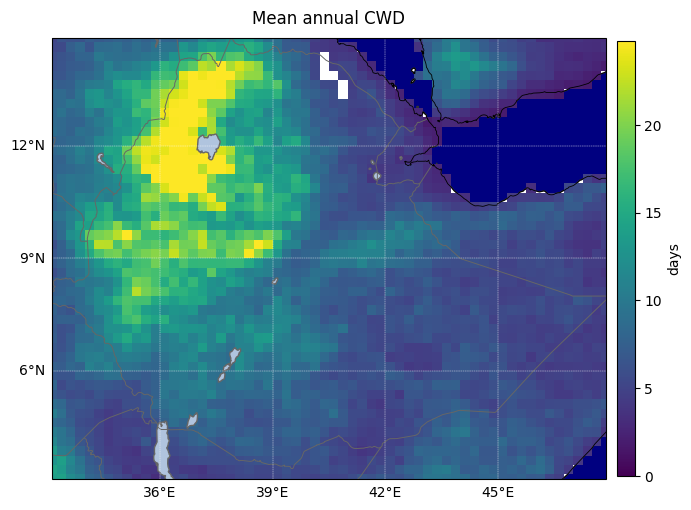

In [273]:
proj = ccrs.PlateCarree()
extent = [float(pr.lon.min()), float(pr.lon.max()),
          float(pr.lat.min()), float(pr.lat.max())]

def style(ax):
    ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2")
    ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
    ax.add_feature(cfeature.BORDERS, edgecolor="0.4", linewidth=0.7)
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.set_extent(extent, crs=proj)
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.3, color="white",
                      linestyle="--", x_inline=False, y_inline=False)
    gl.top_labels = False; gl.right_labels = False
    gl.xformatter = LongitudeFormatter(); gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

# ---- CDD
vmax_cdd = min(float(np.nanpercentile(CDD_mean.values, 98)), 366)
fig = plt.figure(figsize=(6.8, 5.2), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(CDD_mean.lon, CDD_mean.lat, CDD_mean, transform=proj,
                    cmap="viridis", vmin=0, vmax=vmax_cdd, shading="auto")
style(ax)
cb = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02, aspect=25)
cb.set_label("days")
ax.set_title("Mean annual CDD")
plt.show()

# ---- CWD
vmax_cwd = min(float(np.nanpercentile(CWD_mean.values, 98)), 366)
fig = plt.figure(figsize=(6.8, 5.2), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(CWD_mean.lon, CWD_mean.lat, CWD_mean, transform=proj,
                    cmap="viridis", vmin=0, vmax=vmax_cwd, shading="auto")
style(ax)
cb = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02, aspect=25)
cb.set_label("days")
ax.set_title("Mean annual CWD")
plt.show()


---

## SPI 

- compute the Standardized Precipitation Index (SPI) at arbitrary time scales (1, 3, 6, 12 months) from your CHIRPS daily file and make quick map



Interpretation cheatsheet (McKee et al.)  

≤ −2.0: Extremely dry  

−1.5 to −1.99: Severely dry  

−1.0 to −1.49: Moderately dry  

−0.99 to 0.99: Near normal  

+1.0 to +1.49: Moderately wet  

+1.5 to +1.99: Severely wet  

≥ +2.0: Extremely wet  




In [ ]:
# normalize
if "latitude" in et_chirps_tp.dims:  ds = et_chirps_tp.rename({"latitude":"lat"})
if "longitude" in et_chirps_tp.dims: ds = et_chirps_tp.rename({"longitude":"lon"})

# pick precip var
for v in ["precip", "pr", "precipitation"]:
    if v in et_chirps_tp.data_vars: 
        pr = et_chirps_tp[v]; 
        break
    else: 
        raise KeyError("precip variable not found")   

pr = pr.sortby("time")
if pr.lat[0] > pr.lat[-1]:
    pr = pr.sortby("lat")

# xclim expects units; CHIRPS daily is mm/day
pr = pr.assign_attrs(units="mm/day")

# ---- Monthly totals then SPI-k (k = 1, 3, 6, 12)
pr_mon = pr.resample(time="MS").sum()  # mm/month

# Choose SPI scale(s)
spi3 = SPI(pr_mon, freq="MS", window=3, dist="gamma", method="ML")

# Example: a map for Aug 2020
spi3_aug2020 = spi3.sel(time="2020-08-01")

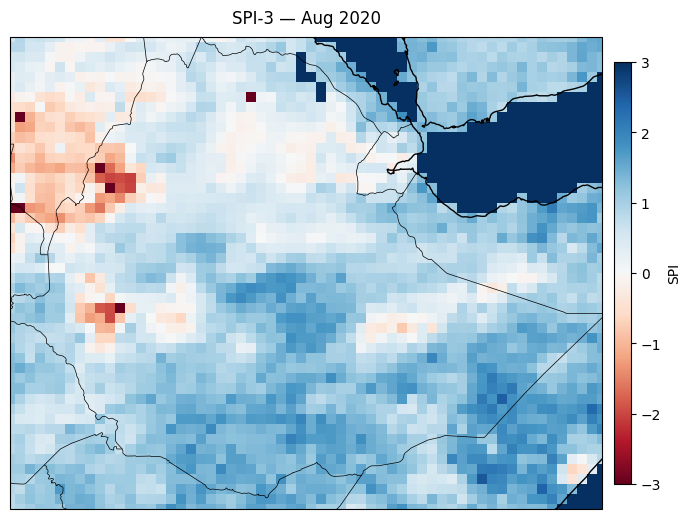

In [280]:
da = spi3.sel(time="2020-08-01") if 'spi3' in globals() else spi3_aug2020
proj = ccrs.PlateCarree()
extent = [float(da.lon.min()), float(da.lon.max()), float(da.lat.min()), float(da.lat.max())]

fig = plt.figure(figsize=(6.8,5.2), constrained_layout=True)
ax  = plt.axes(projection=proj)
im  = ax.pcolormesh(da.lon, da.lat, da, transform=proj, cmap="RdBu", vmin=-3, vmax=3, shading="auto")
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent(extent, crs=proj)
cb = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.02, aspect=25); cb.set_label("SPI")
ax.set_title("SPI-3 — Aug 2020"); plt.show()


---

## Percent of Normal (PoN)

Definition: PoN = 100 × (total over the period ÷ climatological mean for that period).

< 50% — much below normal (severe dryness)

50–75% — below normal

75–125% — near normal (some agencies use 80–120%)

125–150% — above normal

> 150% — much above normal (very wet)

### 

In [293]:
# Start from your DataArray: et_precip [time, lat, lon] in mm/day
pr = et_precip.sortby("time")
if pr.lat[0] > pr.lat[-1]:
    pr = pr.sortby("lat")

# Choose a baseline (use your whole record or a standard like 1991–2020 if available)
base_start, base_end = "2015-01-01", "2024-12-31"
pr_base = pr.sel(time=slice(base_start, base_end))


### Monthly PoN

In [ ]:
# Monthly totals
pr_mon   = pr.resample(time="MS").sum()
base_mon = pr_base.resample(time="MS").sum()

# Monthly climatology (by calendar month)
mon_clim = base_mon.groupby("time.month").mean("time")

# Avoid blow-ups where the climatology is ~0
FLOOR = 1e-6
mon_clim_safe = mon_clim.where(mon_clim > FLOOR)

# Compute PoN: divide first, then multiply by 100
mon_pon = (pr_mon.groupby("time.month") / mon_clim_safe) * 100.0
mon_pon = mon_pon.assign_attrs(long_name="Percent of Normal (monthly)", units="%").rename("pon")

# Example: map for AUG 2016 (monthly resample stamps at first of month)
mon_pon_aug2016 = mon_pon.sel(time="2016-09-01")


### Seasonal PoN

In [344]:
# Seasonal totals (DJF/MAM/JJA/SON)
sea_total  = pr.resample(time="QS-DEC").sum()
base_sea   = pr_base.resample(time="QS-DEC").sum()

# Seasonal climatology
sea_clim = base_sea.groupby("time.season").mean("time")
sea_clim_safe = sea_clim.where(sea_clim > 1e-6)  # or a larger floor like 0.1 mm

# Percent of Normal: divide first (returns a DataArray), THEN multiply
sea_pon = (sea_total.groupby("time.season") / sea_clim_safe) * 100.0
sea_pon = sea_pon.assign_attrs(long_name="Percent of Normal (seasonal)", units="%").rename("pon")

# Example: JJA 2016 (season timestamps: JJA → Jun-01)
sea_pon_jja2016 = sea_pon.sel(time=np.datetime64("2016-06-01"))


### Annual PoN

In [ ]:
pr_ann   = pr.resample(time="YS").sum()
base_ann = pr_base.resample(time="YS").sum()

ann_clim = base_ann.mean("time")           # (lat, lon)
ann_clim_safe = ann_clim.where(ann_clim > 1e-6)

ann_pon = 100.0 * pr_ann / ann_clim_safe

# Example: 2016 map
ann_pon_2016 = ann_pon.sel(time="2016-01-01")


Plot PoN

In [ ]:
def style_axis(ax, extent):
    ax.add_feature(cfeature.OCEAN, facecolor="navy", edgecolor="0.2")
    ax.add_feature(cfeature.LAKES, facecolor="lightsteelblue", edgecolor="0.4")
    ax.add_feature(cfeature.BORDERS, edgecolor="0.4", linewidth=0.7)
    ax.coastlines("10m", linewidth=0.6)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.3, color="white",
                      linestyle="--", x_inline=False, y_inline=False)
    gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LongitudeFormatter(); gl.yformatter=LatitudeFormatter()
    gl.xlocator=mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator=mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

def map_percent_normal(da, title, vmin=50, vcenter=100, vmax=200):
    proj = ccrs.PlateCarree()
    extent = [float(da.lon.min()), float(da.lon.max()),
              float(da.lat.min()), float(da.lat.max())]
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    fig = plt.figure(figsize=(6.8,5.2), constrained_layout=True)
    ax  = plt.axes(projection=proj)
    im  = ax.pcolormesh(da.lon, da.lat, da, transform=proj,
                        cmap="RdBu", norm=norm, shading="auto")
    style_axis(ax, extent)
    cb = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02, aspect=25)
    cb.set_label("% of normal")
    ax.set_title(title)
    plt.show()


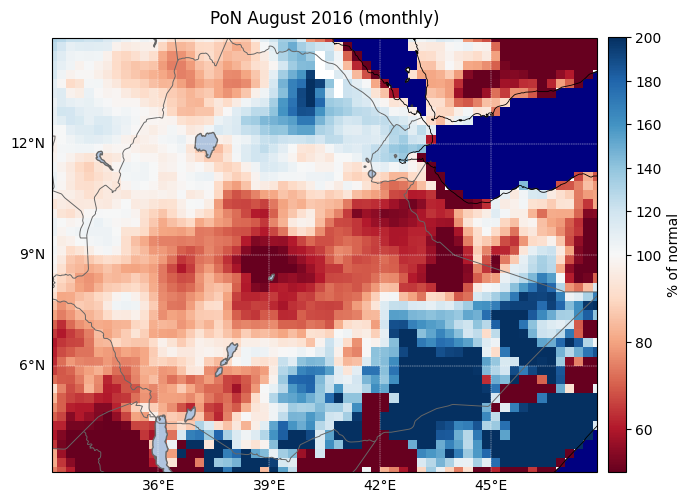

In [339]:
map_percent_normal(mon_pon_aug2016, "PoN August 2016 (monthly)")

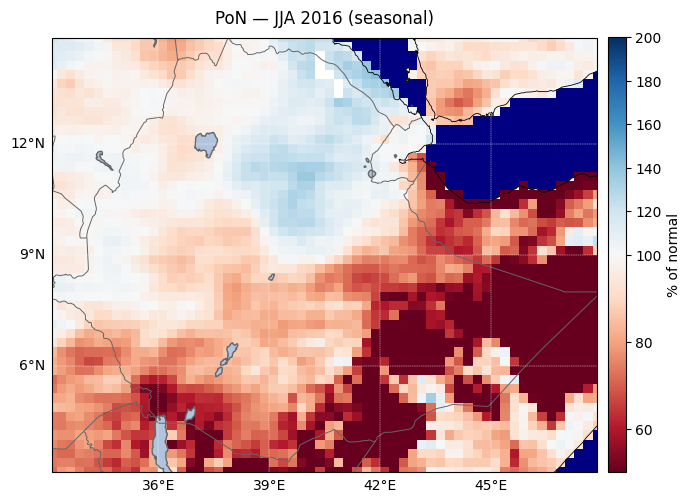

In [345]:
map_percent_normal(sea_pon_jja2016, "PoN — JJA 2016 (seasonal)")


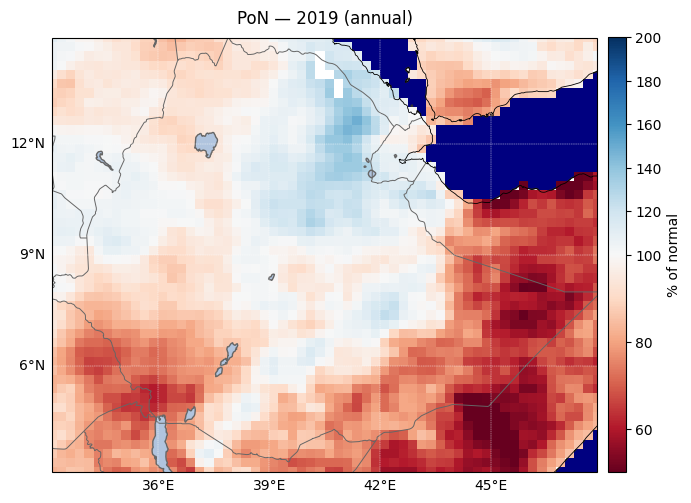

In [342]:
map_percent_normal(ann_pon_2016,    "PoN — 2019 (annual)")
